In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder

The function are defined below

In [ ]:
def sigmoid(z):
  # helps in making exp in limit
  z = np.float128(z)
  y = 1.0/(1 + np.exp(-z))
  # return to normal
  y = np.float64(y)
  return y

def shifted_sigmoid(z):
  z = np.float128(z)
  # in case when there is divide by zero erroe
  y = (1.0/(1 + np.exp(-z)) + 5)
  y = np.float64(y)
  return y

def loss_function(y, y_hat):
  #probabilty loss function
  loss = -np.mean(y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat))
  return loss

def gradients(x, y, y_hat):
  m = x.shape[0]
  #the rate of change of the w and bias
  dw = (1/m) * np.dot(x.T, (y_hat - y))
  db = (1/m) * np.sum(y_hat - y)

  return dw, db


def normalize(x):
  m, n = x.shape
  x = x.astype(np.float)
  #nomalizing the x values
  for i in range(n):
    x = ((x - x.mean(axis=0)) /(x.std(axis=0)) )
  return x

def train(x, y, bs, epochs, lr):
  #defining the small batches and traing them with the help of sigmoid and loss function
  m, n = x.shape
  w = np.zeros((n,1))
  b = 0
  x= normalize(x)
  y = np.array(y)
  y = y.reshape(m, 1)
  losses = []

  for epoch in range(epochs):
    for i in range((m-1)//bs + 1):

      start_i = i * bs
      end_i = start_i + bs
      xb = x[start_i : end_i]
      yb = y[start_i : end_i]

      y_hat = sigmoid(np.dot(xb, w) + b)
      dw, db = gradients(xb, yb, y_hat)
      w -= lr * dw
      b -= lr * db
    l = loss_function(y, sigmoid(np.dot(x, w) + b))
    losses.append(l)

  return w, b, losses

def predict(x, threshold=0.5):
  #predicting the y value incase of threshold changing for plotinh
  pred = sigmoid(np.dot(x, w) + b)
  pred_class = [1 if i> threshold else 0 for i in pred]

  return np.array(pred_class)

def predict1(x, w, b, threshold=0.5):
  #second predict function
  pred = sigmoid(np.dot(x, w) + b)
  pred_class = [1 if i> threshold else 0 for i in pred]

  return np.array(pred_class)

def accuracy(y, y_hat):
    accuracy = np.sum(y == y_hat) / len(y)
    return accuracy

def que1(y_pred, y):
  # for calculating the value of sensitivity, specificity, precision, fmeasure
  true_positive = 0
  false_negative = 0
  true_negative = 0
  false_positive = 0

  for i, j in zip(y, y_pred):
    if i == 1 and i == int(j):
      true_positive += 1
    elif i == 1 and i != int(j):
      false_negative += 1
    elif i == 0 and i == int(j):
      true_negative += 1
    elif i == 0 and i != int(j):
      false_positive += 1
    else:
      continue 

  sensitivity = (true_positive + 1) / ((true_positive + false_negative) + 2)
  specificity = (true_negative + 1)/ ((true_negative + false_positive) + 2)
  precision = (true_positive + 1) / ((true_positive + false_positive) + 2)
  fmeasure = 2*(sensitivity * precision) / (sensitivity + precision)

  return sensitivity, specificity, precision, fmeasure 

def log_likelihood(x, y, w, b):
  #defining another log_likelihood function for newton methord
  sigmoid_probs = sigmoid(np.dot(x, w) + b)
  if sigmoid_probs.any() == 0:
    sigmoid_probs = 0.0001
  elif sigmoid_probs.any() == 1:
    sigmoid_probs = 0.9999
  return np.sum(y * np.log(sigmoid_probs) + (1 - y) * np.log(1 - sigmoid_probs))
    
def gradient_log(x, y, w, b):
  sigmoid_probs = sigmoid(np.dot(x, w) + b)

  x1 = np.sum(np.dot((y-sigmoid_probs), x))
  x2 = np.sum(y - sigmoid_probs)
  return np.array([[x1, x2]])

def hessian(x, y, w, b):
  sigmoid_probs = sigmoid(np.dot(x, w) + b)
  d1 = np.sum((sigmoid_probs * (1 - sigmoid_probs)) * x * x)
  d2 = np.sum((sigmoid_probs * (1 - sigmoid_probs)) * x)
  d3 = np.sum(sigmoid_probs * (1 - sigmoid_probs))

  H = np.array([[d1, d2], [d2, d3]])
  return H

def newtons_methord(x , y):
  m, n = x.shape
  w = np.random.rand(n, 1)
  b = -.4
  delta = np.Infinity
  l = log_likelihood(x, y, w, b)
  boo = 0.000000001
  max_interations = 15
  i = 0 
  while abs(delta) > boo and i < max_interations:
    i += 1
    g = gradient_log(x, y, w, b)
    hess = hessian(x, y, w, b)
    h_inv = np.linalg.inv(hess)
    delta1 = np.dot(h_inv, g.T)
    delta2 = delta1[0][0]
    delta3 = delta1[1][0]

    w += delta2
    b += delta3

    l_new = log_likelihood(x, y, w, b)
    delta = l - l_new
    l = l_new
  return w, b


def logx(x):
  return np.log(x) / (1 - np.log(x))

def mse( y_pred, y):
    y_pred_mean = sum((y - y_pred)**2) / m
    return y_pred_mean

def definechuncksk(dataset, k_value):
    m, n = dataset.shape
    number_of_folds = int(m / k_value)
    chuncks = [dataset[i:i+number_of_folds] for i in range(0,m,number_of_folds)]
    return chuncks

def kfold_train_test_generate(chunks,iteration_number):
    value = len(chunks)
    test_set = chunks[value - iteration_number]
    training_list = []
    for i in range(value):
        if (i != (value - iteration_number)):
            training_list.append(chuncks[i])
    train_set = pd.concat(training_list)
    training_x = train_set.iloc[:, :-1]
    training_y = train_set.iloc[:, -1]
    test_x = test_set.iloc[:, :-1]
    test_y = test_set.iloc[:, -1]
    return training_x, training_y, test_x, test_y
    


(133, 2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in multiply


w: [[ 16.80914252]
 [-28.23049413]]
sensitivity: 0.48484848484848486, specificity: 0.5, precision: 0.9696969696969697, fmeasure: 0.6464646464646465


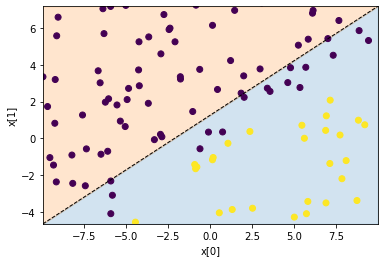

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Attempting to set identical left == right == 0.5 results in singular transformations; automatically expanding.


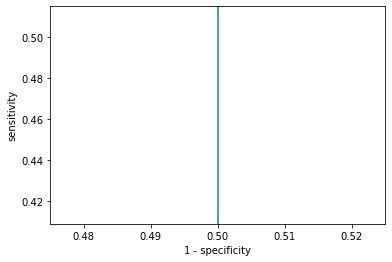

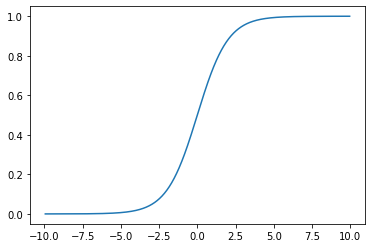

the accuracy is: 0.26865671641791045
sensitivity: 0.015151515151515152, specificity: 0.5, precision: 0.5, fmeasure: 0.029411764705882356


In [ ]:
#question number 7 for data set 1
url = 'https://github.com/fullmetal915/full2/blob/main/data2.csv?raw=true'
df = pd.read_csv(url, header=None)


x = df.iloc[:,:-1].values
y = df.iloc[:, -1].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 1/3, random_state = 0)
print(x_train.shape)
w, b, losses = train(x_train, y_train, bs=20, epochs=1000, lr=0.01)
losses = np.array(losses)
print("w: {}".format(w))

y_pred = predict(x_train)

sensitivity, specificity, precision, fmeasure = que1(y_pred, y_train)

print('sensitivity: {}, specificity: {}, precision: {}, fmeasure: {}'.format(sensitivity, specificity, precision, fmeasure))

c = -b / w[0]
m = -w[0] / w[1]

x_g = np.linspace(x_train.min(), x_train.max(), 1000)
y_g = m * x_g + c
plt.plot(x_g, y_g, 'k', lw=1, ls='--')

plt.fill_between(x_g, y_g, y_g.min(), color='tab:blue', alpha=0.2)
plt.fill_between(x_g, y_g, y_g.max(), color='tab:orange', alpha=0.2)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_pred)
plt.xlim(x_g.min(), x_g.max())
plt.ylim(y_g.min(), y_g.max())
plt.xlabel('x[0]')
plt.ylabel('x[1]')
plt.show()

oneminusspecificity = []
sensitivity_list = []
threshold = np.linspace(0.00001, 0.99999, 500)
for i in range(len(threshold)):
  y_pred = predict(x_train, threshold[i])
  sensitivity, specificity, precision, fmeasure = que1(y_pred, y_train)
  oneminusspecificity.append(1 - specificity)
  
  sensitivity_list.append(sensitivity)

plt.plot(oneminusspecificity, sensitivity_list)
plt.xlabel('1 - specificity')
plt.ylabel('sensitivity') 
plt.xlim(min(oneminusspecificity), max(oneminusspecificity))
plt.ylim(min(sensitivity_list), max(sensitivity_list))
plt.show()

x = np.linspace(x.min(),x.max(), 1000) 
plt.plot(x, sigmoid(x))
plt.show()

y_pred = predict(x_test)

print("the accuracy is: {}".format(accuracy(y_test, y_pred)))

w1, b1 = newtons_methord(x_train, y_train)
y_pred = predict1(x_train, w1, b1)

sensitivity, specificity, precision, fmeasure = que1(y_pred, y_train)
print("sensitivity: {}, specificity: {}, precision: {}, fmeasure: {}".format(sensitivity, specificity, precision, fmeasure))


(266, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


w: [[-2.22879086]
 [ 5.10752053]
 [ 2.12209355]]
sensitivity: 0.9863013698630136, specificity: 0.9919354838709677, precision: 0.993103448275862, fmeasure: 0.9896907216494845


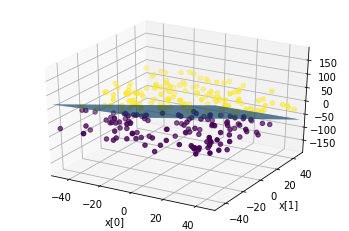

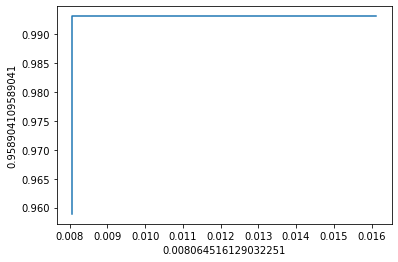

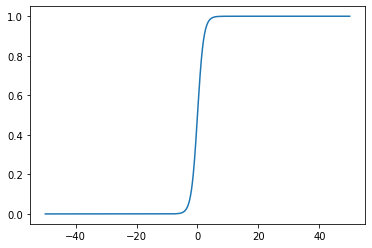

the accuracy is: 0.9850746268656716
sensitivity: 0.6712328767123288, specificity: 0.6129032258064516, precision: 0.6712328767123288, fmeasure: 0.6712328767123288


In [ ]:
url = 'https://github.com/fullmetal915/full2/blob/main/data1.csv?raw=true'
df = pd.read_csv(url, header=None)


x = df.iloc[:,:-1].values
y = df.iloc[:, -1].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 1/3, random_state = 0)
print(x_train.shape)
w, b, losses = train(x_train, y_train, bs=20, epochs=1000, lr=0.01)
losses = np.array(losses)
print("w: {}".format(w))


y_pred = predict(x_train)

sensitivity, specificity, precision, fmeasure = que1(y_pred, y_train)

print('sensitivity: {}, specificity: {}, precision: {}, fmeasure: {}'.format(sensitivity, specificity, precision, fmeasure))



x_g1 = np.linspace(x_train[:, 0].min(), x_train[:, 0].max(), 1000)
x_g2 = np.linspace(x_train[:, 1].min(), x_train[:, 1].max(), 1000)
x_g1, x_g2 = np.meshgrid(x_g1, x_g2)
x_g3 = (-w[0] / w[2]) * x_g1 + (-w[1] / w[2]) * x_g2 - b

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_g1, x_g2, x_g3)

# plt.fill_between(x_g, y_g, y_g.min(), color='tab:blue', alpha=0.2)
# plt.fill_between(x_g, y_g, y_g.max(), color='tab:orange', alpha=0.2)
ax.scatter3D(x_train[:, 0], x_train[:, 1], x_train[:, 2], c=y_pred)
plt.xlim(x_g1.min(), x_g1.max())
plt.ylim(x_g2.min(), x_g2.max())
plt.xlabel('x[0]')
plt.ylabel('x[1]')
plt.show()

oneminusspecificity = []
sensitivity_list = []
threshold = np.linspace(0.00001, 0.99999, 500)
for i in range(len(threshold)):
  y_pred = predict(x_train, threshold[i])
  sensitivity, specificity, precision, fmeasure = que1(y_pred, y_train)
  oneminusspecificity.append(1 - specificity)
  
  sensitivity_list.append(sensitivity)

plt.plot(oneminusspecificity, sensitivity_list)
plt.xlabel(1 - specificity)
plt.ylabel(sensitivity) 
plt.show()

x = np.linspace(x.min(),x.max(), 1000) 
plt.plot(x, sigmoid(x))
plt.show()

y_pred = predict(x_test)

print("the accuracy is: {}".format(accuracy(y_test, y_pred)))

w1, b1 = newtons_methord(x_train, y_train)
y_pred = predict1(x_train, w1, b1)

sensitivity, specificity, precision, fmeasure = que1(y_pred, y_train)
print("sensitivity: {}, specificity: {}, precision: {}, fmeasure: {}".format(sensitivity, specificity, precision, fmeasure))

(133, 2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in multiply


w: [[ 16.80914252]
 [-28.23049413]]
sensitivity: 0.48484848484848486, specificity: 0.5, precision: 0.9696969696969697, fmeasure: 0.6464646464646465


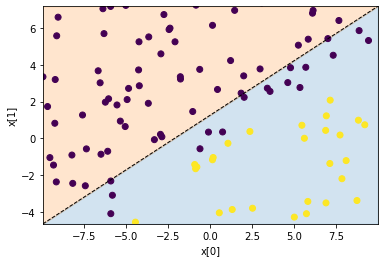

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Attempting to set identical left == right == 0.5 results in singular transformations; automatically expanding.


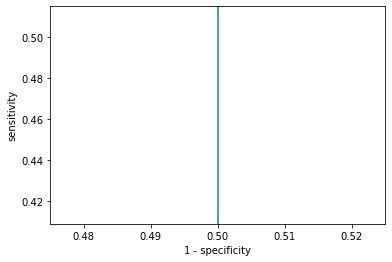

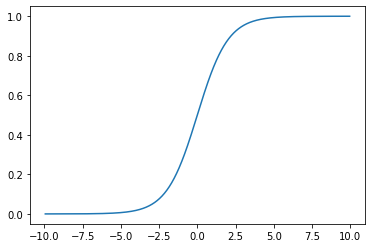

the accuracy is: 0.26865671641791045
sensitivity: 0.015151515151515152, specificity: 0.5, precision: 0.5, fmeasure: 0.029411764705882356


In [ ]:
#question number 7 for data set 1
url = 'https://github.com/fullmetal915/full2/blob/main/data2.csv?raw=true'
df = pd.read_csv(url, header=None)


x = df.iloc[:,:-1].values
y = df.iloc[:, -1].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 1/3, random_state = 0)
print(x_train.shape)
w, b, losses = train(x_train, y_train, bs=20, epochs=1000, lr=0.01)
losses = np.array(losses)
print("w: {}".format(w))

y_pred = predict(x_train)

sensitivity, specificity, precision, fmeasure = que1(y_pred, y_train)

print('sensitivity: {}, specificity: {}, precision: {}, fmeasure: {}'.format(sensitivity, specificity, precision, fmeasure))

c = -b / w[0]
m = -w[0] / w[1]

x_g = np.linspace(x_train.min(), x_train.max(), 1000)
y_g = m * x_g + c
plt.plot(x_g, y_g, 'k', lw=1, ls='--')

plt.fill_between(x_g, y_g, y_g.min(), color='tab:blue', alpha=0.2)
plt.fill_between(x_g, y_g, y_g.max(), color='tab:orange', alpha=0.2)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_pred)
plt.xlim(x_g.min(), x_g.max())
plt.ylim(y_g.min(), y_g.max())
plt.xlabel('x[0]')
plt.ylabel('x[1]')
plt.show()

oneminusspecificity = []
sensitivity_list = []
threshold = np.linspace(0.00001, 0.99999, 500)
for i in range(len(threshold)):
  y_pred = predict(x_train, threshold[i])
  sensitivity, specificity, precision, fmeasure = que1(y_pred, y_train)
  oneminusspecificity.append(1 - specificity)
  
  sensitivity_list.append(sensitivity)

plt.plot(oneminusspecificity, sensitivity_list)
plt.xlabel('1 - specificity')
plt.ylabel('sensitivity') 
plt.xlim(min(oneminusspecificity), max(oneminusspecificity))
plt.ylim(min(sensitivity_list), max(sensitivity_list))
plt.show()

x = np.linspace(x.min(),x.max(), 1000) 
plt.plot(x, sigmoid(x))
plt.show()

y_pred = predict(x_test)

print("the accuracy is: {}".format(accuracy(y_test, y_pred)))

w1, b1 = newtons_methord(x_train, y_train)
y_pred = predict1(x_train, w1, b1)

sensitivity, specificity, precision, fmeasure = que1(y_pred, y_train)
print("sensitivity: {}, specificity: {}, precision: {}, fmeasure: {}".format(sensitivity, specificity, precision, fmeasure))


(266, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in multiply


w: [[-62.42703558]
 [ 16.21927519]
 [-23.79147938]]
sensitivity: 0.9774436090225563, specificity: 0.5, precision: 0.9923664122137404, fmeasure: 0.9848484848484848


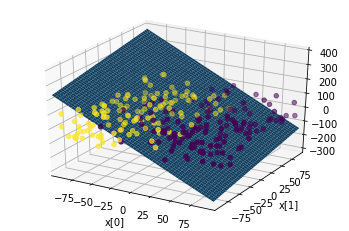

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: Attempting to set identical left == right == 0.5 results in singular transformations; automatically expanding.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: Attempting to set identical bottom == top == 0.9774436090225563 results in singular transformations; automatically expanding.


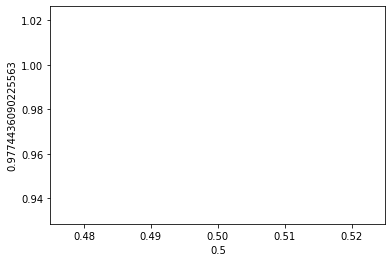

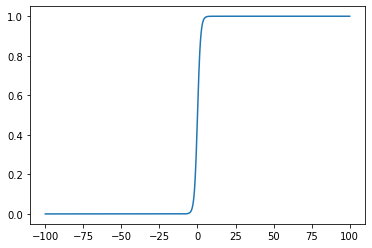

the accuracy is: 0.5149253731343284
sensitivity: 0.5488721804511278, specificity: 0.5, precision: 0.9864864864864865, fmeasure: 0.7053140096618358


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


In [ ]:
url = 'https://github.com/fullmetal915/full2/blob/main/data4.csv?raw=true'
df = pd.read_csv(url, header=None)


x = df.iloc[:,:-1].values
y = df.iloc[:, -1].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 1/3, random_state = 0)
print(x_train.shape)
w, b, losses = train(x_train, y_train, bs=20, epochs=1000, lr=0.01)
losses = np.array(losses)
print("w: {}".format(w))


y_pred = predict(x_train)

sensitivity, specificity, precision, fmeasure = que1(y_pred, y_train)

print('sensitivity: {}, specificity: {}, precision: {}, fmeasure: {}'.format(sensitivity, specificity, precision, fmeasure))



x_g1 = np.linspace(x_train[:, 0].min(), x_train[:, 0].max(), 1000)
x_g2 = np.linspace(x_train[:, 1].min(), x_train[:, 1].max(), 1000)
x_g1, x_g2 = np.meshgrid(x_g1, x_g2)
x_g3 = (-w[0] / w[2]) * x_g1 + (-w[1] / w[2]) * x_g2 - b

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_g1, x_g2, x_g3)

# plt.fill_between(x_g, y_g, y_g.min(), color='tab:blue', alpha=0.2)
# plt.fill_between(x_g, y_g, y_g.max(), color='tab:orange', alpha=0.2)
ax.scatter3D(x_train[:, 0], x_train[:, 1], x_train[:, 2], c=y_pred)
plt.xlim(x_g1.min(), x_g1.max())
plt.ylim(x_g2.min(), x_g2.max())
plt.xlabel('x[0]')
plt.ylabel('x[1]')
plt.show()

oneminusspecificity = []
sensitivity_list = []
threshold = np.linspace(0.00001, 0.99999, 500)
for i in range(len(threshold)):
  y_pred = predict(x_train, threshold[i])
  sensitivity, specificity, precision, fmeasure = que1(y_pred, y_train)
  oneminusspecificity.append(1 - specificity)
  
  sensitivity_list.append(sensitivity)

plt.plot(oneminusspecificity, sensitivity_list)
plt.xlabel(1 - specificity)
plt.ylabel(sensitivity) 
plt.xlim(min(oneminusspecificity), max(oneminusspecificity))
plt.ylim(min(sensitivity_list), max(sensitivity_list))
plt.show()

x = np.linspace(x.min(),x.max(), 1000) 
plt.plot(x, sigmoid(x))
plt.show()

y_pred = predict(x_test)

print("the accuracy is: {}".format(accuracy(y_test, y_pred)))

w1, b1 = newtons_methord(x_train, y_train)
y_pred = predict1(x_train, w1, b1)

sensitivity, specificity, precision, fmeasure = que1(y_pred, y_train)
print("sensitivity: {}, specificity: {}, precision: {}, fmeasure: {}".format(sensitivity, specificity, precision, fmeasure))

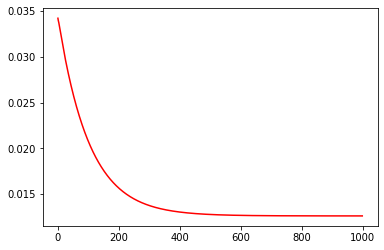

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(epochs),losses ,color="Red")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[[ 3.57396597]
 [-5.66012541]]
b: 0.6746294853990548
[-0.00253335 -0.11030568]
0.731649508250007


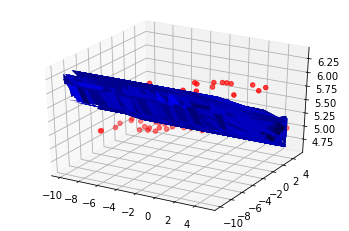

0.06338188978899077


In [ ]:
from sklearn.metrics import mean_squared_error
url = 'https://github.com/fullmetal915/full2/blob/main/data3.csv?raw=true'
df = pd.read_csv(url, header=None)

x = df.iloc[:,:-1].values
y = df.iloc[:, -1].values


w, b, losses = train(x, y, bs=20, epochs=1000, lr=0.01)

y_linear = shifted_sigmoid(np.dot(x, w) + b)

x_train, x_test, y_train, y_test = train_test_split(x, y_linear, test_size = 1/3, random_state = 0)

#plotting the linear regression model

w_linear = np.linalg.solve(np.dot(x.T, x), np.dot(x.T, y))
print(w)
print("b: {}".format(b))
print(w_linear)

#data cleaning
df.fillna(method = 'ffill', inplace = True)

regr = LinearRegression()
regr.fit(x_train, y_train)
print(regr.score(x_test,  y_test))

y_pred = regr.predict(x_test)

fig = plt.figure()

# Add an axes
ax = fig.add_subplot(111,projection='3d')
ax.scatter(x_test[:, 0] , x_test[:, 1] , y_test,  color='red')

X, Y = np.meshgrid(x_test[:, 0], x_test[:, 1])
Z = y_pred
ax.plot_surface(X, Y, Z, color='b')

plt.show()

mse = mean_squared_error(y_true=y_test, y_pred = y_pred)
print(mse)



In [ ]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data", header = None)
del df[0]
df = df[~(df == '?').any(axis=1)]
x=np.array(normalize(df.iloc[:, :-1]))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


y_pred= [1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0], y_test=476    1.0
477    0.0
478    1.0
479    0.0
480    0.0
      ... 
539    0.0
540    0.0
541    0.0
542    0.0
543    0.0
Name: 9, Length: 68, dtype: float64 
y_pred= [0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 1 0
 1 0 0 0 1 1 0 1 1 1 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0], y_test=136    0.0
137    0.0
138    0.0
139    1.0
140    0.0
      ... 
199    1.0
200    1.0
201    0.0
202    0.0
203    0.0
Name: 9, Length: 68, dtype: float64 
y_pred= [0 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 0 1 0 1 1 0 0 1 0 0 0 1 0 0 1 1 0 1 1 0
 1 0 0 1 0 1 1 1 0 0 1 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 1], y_test=272    0.0
273    1.0
274    1.0
275    1.0
276    1.0
      ... 
335    1.0
336    0.0
337    0.0
338    0.0
339    1.0
Name: 9, Length: 68, dtype: float64 
y_pred= [1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 0 1 1 0 1 1 1 1 1 0 1 

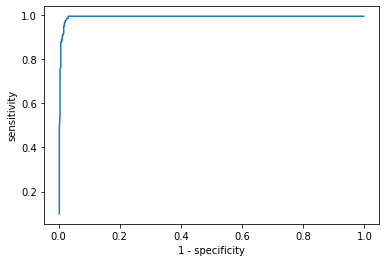

In [ ]:
y = df.iloc[:, -1].values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
label_encoder_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

m, n = x.shape
xy = np.c_[x.reshape(m, -1), y.reshape(m, 1)]
xy = pd.DataFrame(xy)
sensitivity_list = []
specificity_list = []
precision_list =[]
fmeasure_list = []

k_value = 10
chuncks = definechuncksk(xy, k_value)

w =  0
iteration_number_list = []
for i in range(10):
    iteration_number_list.append(random.randint(1,len(chuncks) - 1))

# learning_rate = 0.01
# epochs = 1000
for i in iteration_number_list:
    x_train, y_train, x_test, y_test = kfold_train_test_generate(chuncks, i)
    
    # gradient descent algo
    w, b, losses = train(x_train, y_train, bs=20, epochs=1000, lr=0.01)
    y_pred = predict1(x_test, w, b)
    sensitivity, specificity, precision, fmeasure = que1(y_pred, y_test)
    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)
    precision_list.append(precision)
    fmeasure_list.append(fmeasure)
  

sensitivity_list = sum([i**2 for i in sensitivity_list])/ len(sensitivity_list)
specificity_list = sum([i**2 for i in specificity_list]) / len(specificity_list)
precision_list = sum([i**2 for i in precision_list]) / len(precision_list)
fmeasure_list = sum([i**2 for i in fmeasure_list]) / len(fmeasure_list)
print('sensitivity: {}, specificity: {}, precision: {}, fmeasure: {}'.format(sensitivity_list, specificity_list, precision_list, fmeasure_list))
oneminusspecificity = []
sensitivity_list = []
threshold = np.linspace(0.00001, 0.99999, 500)
for i in range(len(threshold)):
  y_pred = predict(x_train, threshold[i])
  sensitivity, specificity, precision, fmeasure = que1(y_pred, y_train)
  oneminusspecificity.append(1 - specificity)
  
  sensitivity_list.append(sensitivity)

plt.plot(oneminusspecificity, sensitivity_list)
plt.xlabel("1 - specificity")
plt.ylabel("sensitivity") 
plt.show()